# Compare all 4 models

In [1]:
import utils
import matplotlib.pyplot as plt
import numpy as np
from model import Model
import torch
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
config = utils.read_config()
config['dir']['results'] = 'results_final_nopriorx'

In [7]:
# set seeds
utils.set_seeds(config['seed'])
behaviour_data_all, spikes, trial_indices = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data_all, spikes = [x[time_from:, :] for x in behaviour_data_all], [x[time_from:, :] for x in spikes]
stim_idx, choice_idx, amp_idx, prev_choice_idx = 9, 3, 24, 6
stim = [x[0, stim_idx] for x in behaviour_data_all]
choice = [x[0, choice_idx] for x in behaviour_data_all]
# normalize amp by max value
num_contacts = [np.sum(x[:, 15:19], axis=1) for x in behaviour_data_all]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)
# convert to torch tensors
behaviour_data = np.array(behaviour_data)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = np.array(spikes)
num_trials, time_bins, emissions_dim = spikes.shape
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, num_contacts_train, num_contacts_test = train_test_split(behaviour_data, spikes, num_contacts, test_size=0.2, random_state=7)
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, amp_train, amp_test = train_test_split(behaviour_data, spikes, amp, test_size=0.3, random_state=7)
# further split test into test and val
# behaviour_data_test, behaviour_data_val, spikes_test, spikes_val, amp_test, amp_val = train_test_split(behaviour_data_test, spikes_test, amp_test, test_size=0.5, random_state=7)
trials_train, trials_test = len(behaviour_data_train), len(behaviour_data_test)
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0]), np.mean(behaviour_data_train[:, 1])))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0]), np.mean(behaviour_data_test[:, 1])))
# print("Val distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_val[:, 0]), np.mean(behaviour_data_val[:, 1]), np.mean(behaviour_data_val[:, 2])))
# labels
y_stim_train, y_stim_test = behaviour_data_train[:, 0], behaviour_data_test[:, 0]
y_choice_train, y_choice_test = behaviour_data_train[:, 1], behaviour_data_test[:, 1]

Train distribution of Stimulus: 0.46875, Choice: 0.359375
Test distribution of Stimulus: 0.5454545454545454, Choice: 0.48484848484848486


In [10]:
config['vae_gp']['monotonic']['use'] = False
config['decoder']['which'] = ''
config['vae_gp']['load_stage2'] = False
# model 1: no uni, no cnn
m1 = Model(config, input_dim=14)
m1.load_model('best')
# model 2: uni, no cnn
config['vae_gp']['monotonic']['use'] = True
config['decoder']['which'] = ''
m2 = Model(config, input_dim=14)
m2.load_model('best')
# model 3: no uni, cnn
config['vae_gp']['monotonic']['use'] = False
config['decoder']['which'] = 'cnn_indi'
m3 = Model(config, input_dim=14)
m3.load_model('best')
# model 4: uni, cnn
config['vae_gp']['monotonic']['use'] = True
config['decoder']['which'] = 'cnn_indi'
m4 = Model(config, input_dim=14)
m4.load_model('best')

Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable parameters in Posterior Mean X: 163
Number of trainable parameters in Posterior Mean Z: 163
Number of trainable parameters in Block Diagonal Z: 163
Number of trainable parameters in Cov X: 217
Number of trainable parameters in VAE: 3190
No behavior decoder
Loaded model
Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable parameters in Posterior Mean X: 163
Number of trainable parameters in Posterior Mean Z: 163
Number of trainable parameters in Block Diagonal Z: 163
Number of trainable parameters in Cov X: 217
Number of trainable parameters in VAE: 3353
No behavior decoder
Loaded model
Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable para

In [11]:
t = np.arange(-2, 0.5, 0.1)
colors = ['red', 'blue', 'green', 'black', 'yellow', 'pink']

def get_res(model):
    with torch.no_grad():
        model.eval()        
        # run on only test
        vae_output, _, amp_out_test = model.forward(torch.tensor(spikes_test, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)  
        y_recon_test, x_mu_test, z_mu_test, x_A_test, z_A_test, x_test, z_test, z_test_presoftmax, g_test = model.vae.extract_relevant(vae_output)
        # run only on train
        vae_output, _, amp_out_train = model.forward(torch.tensor(spikes_train, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)
        y_recon_train, x_mu_train, z_mu_train, x_A_train, z_A_train, x_train, z_train, z_train_presoftmax, g_train = model.vae.extract_relevant(vae_output)
        # # run only on val
        # vae_output, _, amp_out_val = model.forward(spikes_val, n_samples=1, use_mean_for_decoding=True)
        # y_recon_val, x_mu_val, z_mu_val, x_A_val, z_A_val, x_val, z_val, z_val_presoftmax, g_val = model.vae.extract_relevant(vae_output)
        # run on both
        vae_output, _, amp_out_all = model.forward(torch.tensor(spikes, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)
        y_recon_all, x_mu_all, z_mu_all, x_A_all, z_A_all, x_all, z_all, z_presoftmax_all, g_all = model.vae.extract_relevant(vae_output)
    return z_all, x_mu_all, z_train, x_mu_train, z_test, x_mu_test

In [12]:
# get all outputs
z_all_1, x_mu_all_1, z_train_1, x_mu_train_1, z_test_1, x_mu_test_1 = get_res(m1)
z_all_2, x_mu_all_2, z_train_2, x_mu_train_2, z_test_2, x_mu_test_2 = get_res(m2)
z_all_3, x_mu_all_3, z_train_3, x_mu_train_3, z_test_3, x_mu_test_3 = get_res(m3)
z_all_4, x_mu_all_4, z_train_4, x_mu_train_4, z_test_4, x_mu_test_4 = get_res(m4)

In [ ]:
def plot_z(model_id, z):
    z_std = np.std(z, axis=0)
    z_avg = np.mean(z, axis=0)
    # make x ticks of range 0.1 from -2 to 0.5
    bin_len = config['shape_dataset']['win_len']
    t = np.arange(-2, 0.5, bin_len)
    for i in range(z.shape[2]):
        plt.plot(t, z_avg[:, i], label='z{}'.format(i+1), color=colors[i], linewidth=7.0)    
        plt.fill_between(t, z_avg[:, i]-z_std[:, i], z_avg[:, i]+z_std[:, i], alpha=0.3, color=colors[i])
    # plt.set_title('z')
    plt.xlabel('Time (s)')    
    if model_id == 4:        
        plt.legend()
    # if model_id != 1:
    #     plt.yticks([])

In [ ]:
plt.clf()
plt.rcParams.update({'font.size': 28})
plt.figure(figsize=(28, 6))

plt.subplot(1, 4, 1)
plot_z(1, z_all_1)
plt.title('M1: No Unimodality, No CNN')

plt.subplot(1, 4, 2)
plot_z(2, z_all_2)
plt.title('M2: Unimodality, No CNN')

plt.subplot(1, 4, 3)
plot_z(3, z_all_3)
plt.title('M3: No Unimodality, CNN')

plt.subplot(1, 4, 4)
plot_z(4, z_all_4)
plt.title('M4: Unimodality, CNN')
# plt.show()
plt.tight_layout()
plt.savefig('paper/z_avg.pdf')

In [ ]:
def plot_x(model_id, x_data, behave_data, gs_obj, fig, ticks=False):
    def plot_cont_latent(data, label, axs, ax_id, linestyle):
        num_latents = data.shape[1]
        for i in range(num_latents):
            axs[ax_id].plot(t, data[:, i], label='{}_x{}'.format(label, i+1),
                            color=colors[i], linestyle=linestyle, linewidth=4.0)        
    # group x for stimulus and choice
    stim, choice = behave_data[:, 0], behave_data[:, 1]
    # group x for stimulus
    num = 200
    x_stim_left, x_stim_right = x_data[stim == 1][:num].mean(axis=0), x_data[stim == 0][:num].mean(axis=0)
    x_choice_left, x_choice_right = x_data[choice == 1].mean(axis=0), x_data[choice == 0].mean(axis=0)
    # plot x for stimulus and choice    
    # title for gs_obj    
    gssub = gs_obj.subgridspec(2, 1)
    ax1 = fig.add_subplot(gssub[0])
    ax2 = fig.add_subplot(gssub[1])
    axs = [ax1, ax2]

    plot_cont_latent(x_stim_left, 'stim left', axs, 0, '-')
    plot_cont_latent(x_stim_right, 'stim right', axs, 0, 'dashed')
    # plot_cont_latent(x_data.mean(axis=0), 'both', 0, ':')
    axs[0].set_title('M{}'.format(model_id))
    axs[0].set_xticks([])
    axs[0].set_yticks([])        

    plot_cont_latent(x_choice_left, 'choice left', axs, 1, '-')
    plot_cont_latent(x_choice_right, 'choice right', axs, 1, 'dashed')
    
    axs[1].set_xlabel('Time (s)')    
    axs[1].set_yticks([]) 
    axs[1].set_xticks([-2, -1, 0])
    if model_id == 1:
        axs[0].set_ylabel('Grouped by stimulus')
        axs[1].set_ylabel('Grouped by choice')
    if ticks:
        plt.rcParams.update({'font.size': 15})
        axs[1].legend()
        axs[0].legend()
        plt.rcParams.update({'font.size': 26})

In [ ]:
fig = plt.figure(figsize=(28, 12))
fig.tight_layout()
# gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
# plot_x(x_mu_all_1, behaviour_data, gs[0, 0], fig)
# plot_x(x_mu_all_2, behaviour_data, gs[0, 1], fig)
# plot_x(x_mu_all_3, behaviour_data, gs[1, 0], fig)
# plot_x(x_mu_all_4, behaviour_data, gs[1, 1], fig, ticks=True)
gs = fig.add_gridspec(1, 4, hspace=0.2, wspace=0.2)
plot_x(1, x_mu_all_1, behaviour_data, gs[0], fig)
plot_x(2, x_mu_all_2, behaviour_data, gs[1], fig)
plot_x(3, x_mu_all_3, behaviour_data, gs[2], fig)
plot_x(4, x_mu_all_4, behaviour_data, gs[3], fig, ticks=True)
plt.savefig('paper/x_avg.pdf')

In [ ]:
def peak_window_decode(z_mu_train, z_mu_test, x_mu_train, x_mu_test, behav):
    # pick bins around peak z
    # decoding_from = 'spikes' # spikes or mu
    decoding_from = 'mu' # spikes or mu
    # Thresholding based on z to keep only relevant time bins
    z_dim = z_mu_train.shape[-1]
    x_dim = x_mu_train.shape[-1]

    if behav == 'stim':
        y_train, y_test = y_stim_train, y_stim_test
    else:
        y_train, y_test = y_choice_train, y_choice_test
    

    # list_c = [0.1, 0.5, 1, 2, 5]
    list_c = [5]
    one_sided_window = 1
    # concatenate spikes with one sided window on both sides with zeros
    spikes_train_ = np.concatenate([np.zeros((len(spikes_train), one_sided_window, emissions_dim)), spikes_train, np.zeros((len(spikes_train), one_sided_window, emissions_dim))], axis=1)
    spikes_test_ = np.concatenate([np.zeros((len(spikes_test), one_sided_window, emissions_dim)), spikes_test, np.zeros((len(spikes_test), one_sided_window, emissions_dim))], axis=1)

    for i in range(z_dim):        
        # set spikes where z is not i to 0
        if decoding_from == 'spikes':
            x_train, x_test = spikes_train_.copy(), spikes_test_.copy()
        else:
            x_train = np.concatenate([np.zeros((len(x_mu_train), one_sided_window, x_dim)), x_mu_train, np.zeros((len(x_mu_train), one_sided_window, x_dim))], axis=1)
            x_test = np.concatenate([np.zeros((len(x_mu_test), one_sided_window, x_dim)), x_mu_test, np.zeros((len(x_mu_test), one_sided_window, x_dim))], axis=1)        
        # print(x_train.shape, x_test.shape)
        # find time bin where z peaks
        argmax_z_train = np.argmax(z_mu_train[:, :, i], axis=1)
        # print(argmax_z_train)
        argmax_z_test = np.argmax(z_mu_test[:, :, i], axis=1)    
        # take one sided window
        x_train = np.array([x[argmax_z_train[j]:argmax_z_train[j]+2*one_sided_window+1] for j, x in enumerate(x_train)]).reshape(x_train.shape[0], -1)
        x_test = np.array([x[argmax_z_test[j]:argmax_z_test[j]+2*one_sided_window+1] for j, x in enumerate(x_test)]).reshape(x_test.shape[0], -1)
        
        for c in list_c:
            # train svm        
            clf = SVC(C=c)
            # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
            clf.fit(x_train, y_train)
            # predict
            pred_test = clf.predict(x_test)
            pred_train = clf.predict(x_train)
            # calculate accuracy
            test_accuracy = round(accuracy_score(y_test, pred_test), 3)
            train_accuracy = round(accuracy_score(y_train, pred_train), 3)
            print("Decoding {} from z{}: C: {}, Train accuracy: {}, Test accuracy: {}".format(behav, i, c, train_accuracy, test_accuracy))        
    print("\n\n")

In [ ]:
def decode_from_argmax(z_mu_train, z_mu_test, x_mu_train, x_mu_test, behav):

    # decoding_from = 'spikes' # spikes or mu
    decoding_from = 'mu' # spikes or mu
    # Thresholding based on z to keep only relevant time bins
    z_dim = z_mu_train.shape[-1]
    argmax_z_train = np.argmax(z_mu_train, axis=2)
    argmax_z_test = np.argmax(z_mu_test, axis=2)

    if behav == 'stim':
        y_train, y_test = y_stim_train, y_stim_test
    else:
        y_train, y_test = y_choice_train, y_choice_test
    # y_train, y_test = y_prev_choice_train, y_prev_choice_test

    list_c = [0.1, 0.5, 1, 2, 5, 10]

    for i in range(z_dim):
        # set spikes where z is not i to 0
        if decoding_from == 'spikes':
            x_train, x_test = spikes_train.copy(), spikes_test.copy()
        else:
            x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
        x_train[argmax_z_train != i] = 0
        x_test[argmax_z_test != i] = 0
        # # take only first 10 time bins
        # x_train, x_test = x_train[:, :10], x_test[:, :10]
        # print number of bins kept
        print("Number of time bins kept for z = {}: {}".format(i, np.mean(argmax_z_train == i)))
        for c in list_c:
            # train svm        
            clf = SVC(C=c)
            clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
            # predict
            pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
            pred_train = clf.predict(x_train.reshape(x_train.shape[0], -1))
            # calculate accuracy
            test_accuracy = round(accuracy_score(y_test, pred_test), 3)
            train_accuracy = round(accuracy_score(y_train, pred_train), 3)
            print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))


In [ ]:
print('m1')
peak_window_decode(z_train_1, z_test_1, x_mu_train_1, x_mu_test_1, 'stim')
peak_window_decode(z_train_1, z_test_1, x_mu_train_1, x_mu_test_1, 'choice')
print("argmax")
decode_from_argmax(z_train_1, z_test_1, x_mu_train_1, x_mu_test_1, 'stim')
decode_from_argmax(z_train_1, z_test_1, x_mu_train_1, x_mu_test_1, 'choice')

In [ ]:
print('m2')
peak_window_decode(z_train_2, z_test_2, x_mu_train_2, x_mu_test_2,  'stim')
peak_window_decode(z_train_2, z_test_2, x_mu_train_2, x_mu_test_2,  'choice')
print("argmax")
decode_from_argmax(z_train_2, z_test_2, x_mu_train_2, x_mu_test_2, 'stim')
decode_from_argmax(z_train_2, z_test_2, x_mu_train_2, x_mu_test_2, 'choice')

In [ ]:
print('m3')
peak_window_decode(z_train_3, z_test_3, x_mu_train_3, x_mu_test_3,  'stim')
peak_window_decode(z_train_3, z_test_3, x_mu_train_3, x_mu_test_3,  'choice')
print("argmax")
decode_from_argmax(z_train_3, z_test_3, x_mu_train_3, x_mu_test_3, 'stim')
decode_from_argmax(z_train_3, z_test_3, x_mu_train_3, x_mu_test_3, 'choice')

In [ ]:
print('m4')
peak_window_decode(z_train_4, z_test_4, x_mu_train_4, x_mu_test_4,  'stim')
peak_window_decode(z_train_4, z_test_4, x_mu_train_4, x_mu_test_4,  'choice')
print("argmax")
decode_from_argmax(z_train_4, z_test_4, x_mu_train_4, x_mu_test_4, 'stim')
decode_from_argmax(z_train_4, z_test_4, x_mu_train_4, x_mu_test_4, 'choice')

# Single-trial

In [13]:
def plot_single(model_id, trial_idx, x, z, contacts, behavior_data, gs_obj, fig):
    # plot a random trial
    stim, choice = behaviour_data[:, 0], behaviour_data[:, 1]
    
    gssub = gs_obj.subgridspec(2, 1)
    ax1 = fig.add_subplot(gssub[0])
    ax2 = fig.add_subplot(gssub[1])
    # ax3 = fig.add_subplot(gssub[2])
    axs = [ax1, ax2]
        
    axs[0].plot(t, z[trial_idx, :, 0], label='z1', marker='o', color=colors[0], linewidth=4.0)
    axs[0].plot(t, z[trial_idx, :, 1], label='z2', marker='o', color=colors[1], linewidth=4.0)
    axs[0].plot(t, z[trial_idx, :, 2], label='z3', marker='o', color=colors[2], linewidth=4.0)
    axs[0].set_title('M{}'.format(model_id+1))        
        
    axs[0].set_xticks([])
    # plot num contacts
    axs[1].plot(t, num_contacts[trial_idx], marker='o', label='num contacts', linewidth=4.0)
    # axs[1].set_title('num contacts and amplitude of whisk')
    axs[1].set_xlabel('Time (s)')
    # axs[1].legend(loc='upper left')
    # plot x
    # axs[2].plot(t, x[trial_idx, :, 0], label='x0', marker='o', color=colors[0])
    # axs[2].plot(t, x[trial_idx, :, 1], label='x1', marker='o', color=colors[1])
    # axs[2].plot(t, x[trial_idx, :, 2], label='x2', marker='o', color=colors[2])    
    if model_id == 0:   
        axs[0].legend()     
        axs[0].set_ylabel('z')
        axs[1].set_ylabel('Num contacts')
        # axs[2].set_ylabel('x')
    # axs[2].set_title('x, stimulus: {}, choice: {}'.format(stim[trial_idx].astype(int), choice[trial_idx].astype(int)))

In [14]:
t = np.arange(-2, 0.5, 0.1)

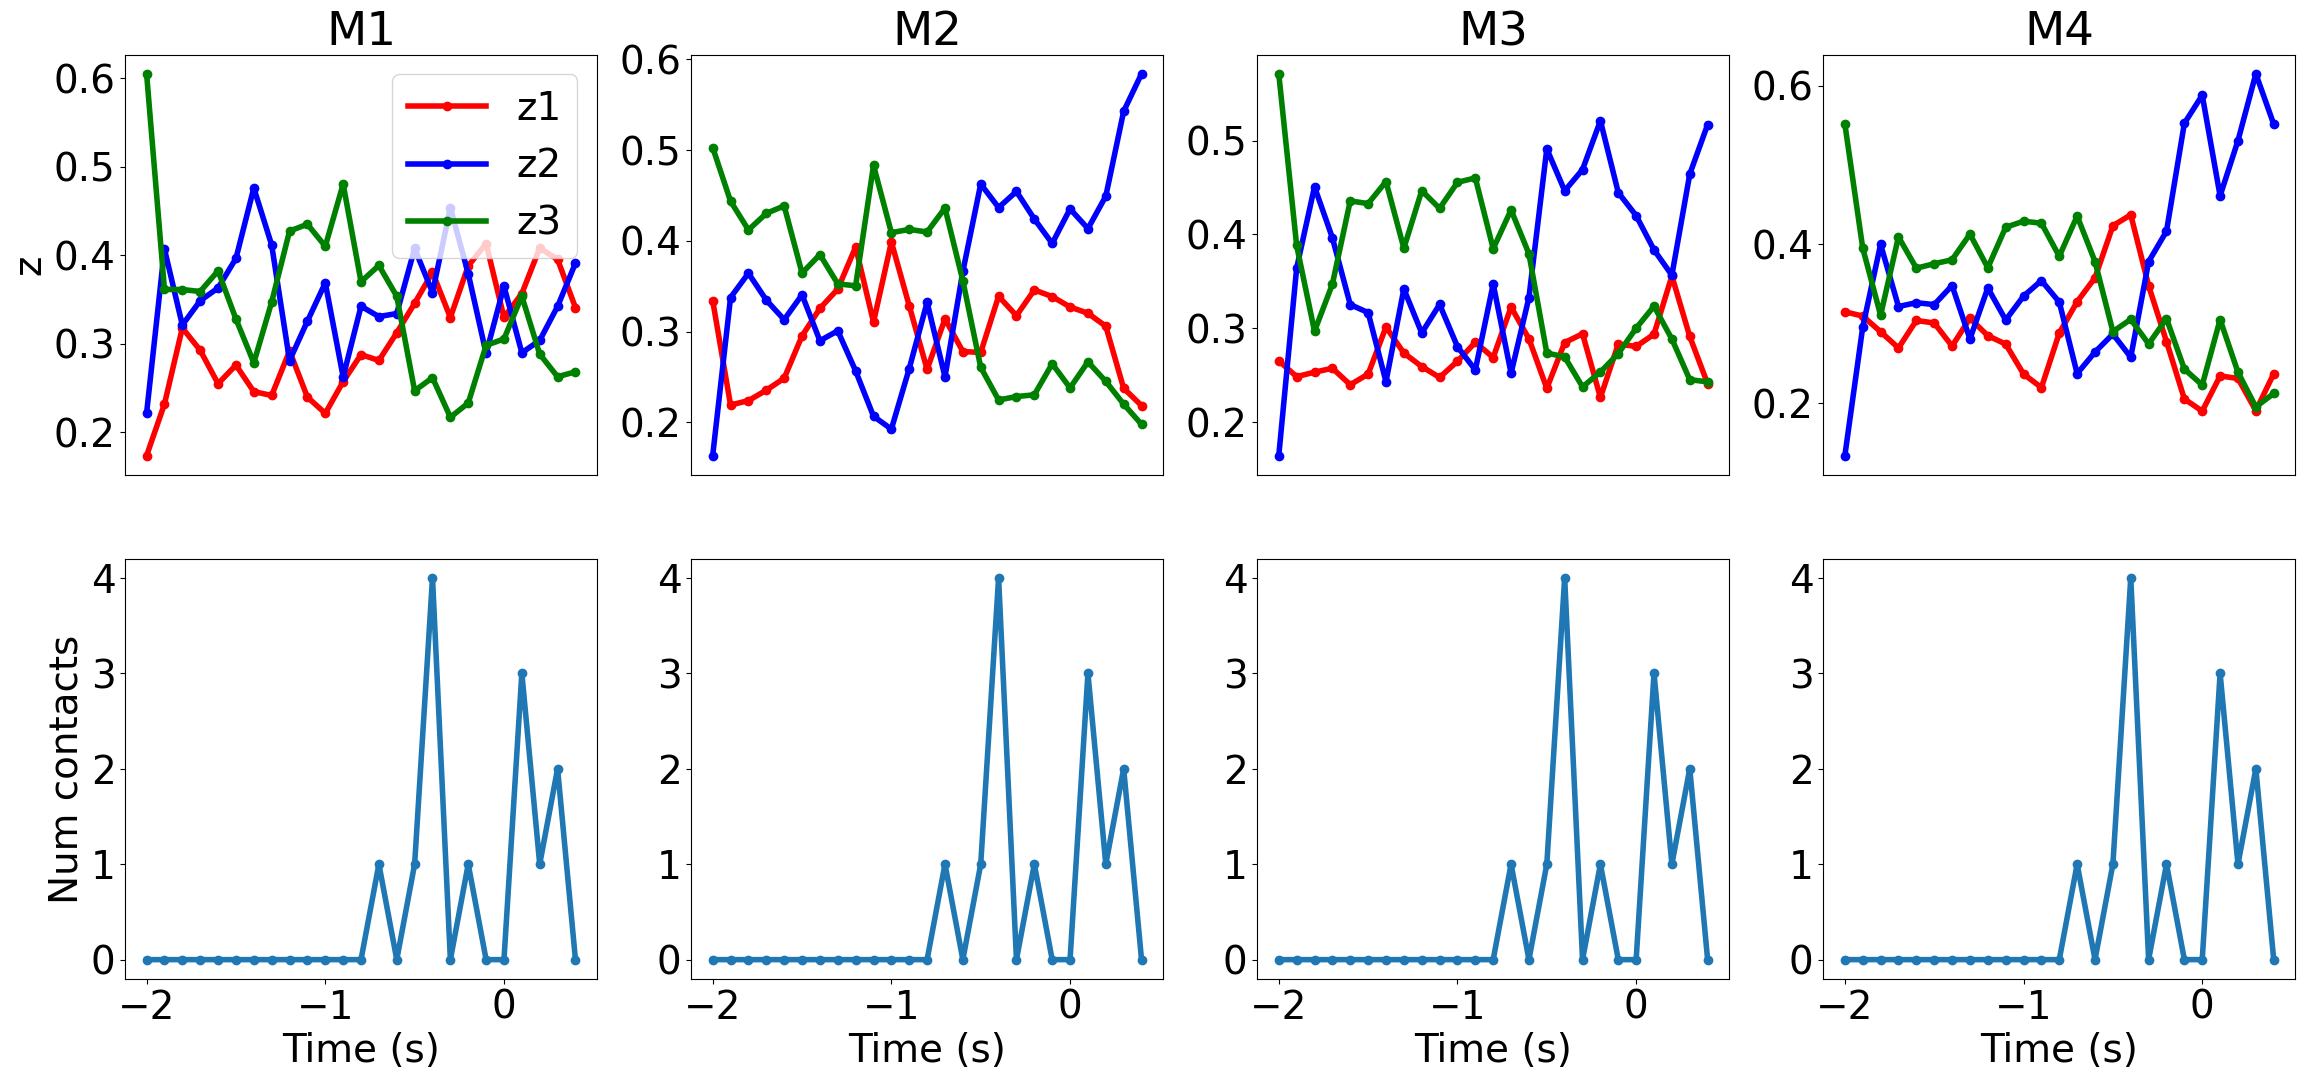

In [15]:
trial_idx = np.random.randint(len(z_all_1))
trial_idx = 123
# print("Trial idx: ", trial_idx)
# fig = plt.figure(figsize=(12, 18))
# fig.tight_layout()
# gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
# plot_single(trial_idx, x_mu_all_1, z_all_1, num_contacts, behaviour_data, gs[0, 0], fig)
# plot_single(trial_idx, x_mu_all_2, z_all_2, num_contacts, behaviour_data, gs[0, 1], fig)
# plot_single(trial_idx, x_mu_all_3, z_all_3, num_contacts, behaviour_data, gs[1, 0], fig)
# plot_single(trial_idx, x_mu_all_4, z_all_4, num_contacts, behaviour_data, gs[1, 1], fig)
plt.rcParams.update({'font.size': 28})
fig = plt.figure(figsize=(28, 12))
fig.tight_layout()
gs = fig.add_gridspec(1, 4)
plot_single(0, trial_idx, x_mu_all_1, z_all_1, num_contacts, behaviour_data, gs[0], fig)
plot_single(1, trial_idx, x_mu_all_2, z_all_2, num_contacts, behaviour_data, gs[1], fig)
plot_single(2, trial_idx, x_mu_all_3, z_all_3, num_contacts, behaviour_data, gs[2], fig)
plot_single(3, trial_idx, x_mu_all_4, z_all_4, num_contacts, behaviour_data, gs[3], fig)
plt.savefig('paper/single_trial.pdf')

# Bits/Spike computation

In [ ]:
def bps(model):    
    with torch.no_grad():
        model.eval()        
        # run on only test
        vae_output, _, amp_out_test = model.forward(torch.tensor(spikes_test, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)  
        y_recon_test, x_mu_test, z_mu_test, x_A_test, z_A_test, x_test, z_test, z_test_presoftmax, g_test = model.vae.extract_relevant(vae_output)
        # run only on train
        vae_output, _, amp_out_train = model.forward(torch.tensor(spikes_train, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)
        y_recon_train, x_mu_train, z_mu_train, x_A_train, z_A_train, x_train, z_train, z_train_presoftmax, g_train = model.vae.extract_relevant(vae_output)        

    # compute bits/spike
    bits_per_spike_train = utils.bits_per_spike(y_recon_train, spikes_train)
    bits_per_spike_test = utils.bits_per_spike(y_recon_test, spikes_test)    
    
    print("Bits per spike train: {}, test: {}".format(np.sum(bits_per_spike_train), np.sum(bits_per_spike_test)))

In [ ]:
bps(m1)
bps(m2)
bps(m3)
bps(m4)

# Decoding using CNN

In [ ]:
import decoder
nsamps = config['num_samples_train']

decode_with = 'z'
# decode_with = 'spikes'
behaviour_data_train = torch.tensor(behaviour_data_train, dtype=torch.float32)
behaviour_data_test = torch.tensor(behaviour_data_test, dtype=torch.float32)

def eval_cnn(x_train, x_test, z_train, z_test):
    
    config = utils.read_config()

    if decode_with == 'z':
        xz_list = [1, 1, 1]
        x_train = torch.tensor(x_train, dtype=torch.float32)
        x_test = torch.tensor(x_test, dtype=torch.float32)
    else:
        xz_list = [14, 14, 14]
        x_train = torch.tensor(spikes_train, dtype=torch.float32).repeat(1, 1, 3)
        x_test = torch.tensor(spikes_test, dtype=torch.float32).repeat(1, 1, 3)  
        config['decoder']['cnn']['channels'] = [4, 4]
        config['decoder']['cnn']['kernel_size'] = 3

    z_train = torch.tensor(z_train, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)

    config['decoder']['stimulus_latent'] = 1
    config['decoder']['choice_latent'] = 1
    config['decoder']['cnn']['normalize_trial_time'] = False
    config['decoder']['cnn']['which_forward'] = 'onlyx'    

    # train the linear decoder for behavior
    # create linear decoder
    config['decoder']['stimulus_weight'] = 1
    config['decoder']['choice_weight'] = 1
    config['decoder']['cnn']['lr'] = 0.003
    # config['decoder']['cnn']['which_forward'] = 'pool'
    linear_decoder = decoder.CNNDecoderIndividual(config, xz_list)
    # print number of trainable parameters
    print("Number of trainable parameters: {}".format(sum(p.numel() for p in linear_decoder.parameters() if p.requires_grad)))
    
    decoder_train_l, decoder_test_l = [], []

    num_epochs = 1000    
    for epoch in range(num_epochs):    
        # forward pass        
        linear_decoder.train()        
        behavior_pred = linear_decoder(x_train, z_train)[0]
        # behavior_pred = linear_decoder(x_test, z_test)[0]
        
        loss = linear_decoder.loss(behavior_pred, behaviour_data_train, None, None)
        # loss = linear_decoder.loss(behavior_pred, behaviour_data_test, None, None)

        # backward pass
        linear_decoder.optimizer.zero_grad()        
        loss.backward()
        linear_decoder.optimizer.step()        
        epoch_loss = loss.item()    
        decoder_train_l.append(epoch_loss)
        # test loss
        if (epoch+1) % 100 == 0:
            linear_decoder.eval()
            test_pred = linear_decoder(x_test, z_test)[0]
            # train_pred = linear_decoder(x_train, z_train)[0]
            # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
            test_loss = linear_decoder.loss(test_pred, behaviour_data_test, None, None).item()        
            # test_loss = linear_decoder.loss(train_pred, behaviour_data_train, None, None).item()  

            decoder_test_l.append(test_loss)
            print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, decoder_train_l[-1], decoder_test_l[-1]))
        
    with torch.no_grad():
        behavior_pred_train = linear_decoder(x_train, z_train)[0].detach()
        behavior_pred_test = linear_decoder(x_test, z_test)[0].detach()
        # behavior_pred_train = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
        # behavior_pred_test = linear_decoder(mu_test[:, :, :2], mu_test[:, :, 2:])
    # # accuracy    
    stim_train = accuracy_score(behaviour_data_train[:, 0].numpy(), (behavior_pred_train[:, 0] > 0).numpy())
    stim_test = accuracy_score(behaviour_data_test[:, 0].numpy(), (behavior_pred_test[:, 0] > 0).numpy())    
    choice_train = accuracy_score(behaviour_data_train[:, 1].numpy(), (behavior_pred_train[:, 1] > 0).numpy())
    choice_test = accuracy_score(behaviour_data_test[:, 1].numpy(), (behavior_pred_test[:, 1] > 0).numpy())
    print("Train Stim: {}, Test Stim: {}, Train Choice: {}, Test Choice: {}".format(stim_train, stim_test, choice_train, choice_test))
    return stim_train, stim_test, choice_train, choice_test

In [ ]:
# eval_cnn(x_mu_train_1, x_mu_test_1, z_train_1, z_test_1)
# eval_cnn(x_mu_train_2, x_mu_test_2, z_train_2, z_test_2)
eval_cnn(x_mu_train_3, x_mu_test_3, z_train_3, z_test_3)
# eval_cnn(x_mu_train_4, x_mu_test_4, z_train_4, z_test_4)

In [ ]:
import pickle
# load x and z from SLDS models
base_pth = '/Users/mithileshvaidya/Code/VAE/pi-vae-main/slds_results'
final_x, final_z = [], []
for i in range(4):
    with open(base_pth + '/m{}.pkl'.format(i+1), 'rb') as f:
        x, z, y = pickle.load(f)
        final_x.append(np.array(x)); final_z.append(z);


In [ ]:
# convert to one hot
def one_hot(x, num_classes):
    # x is of shape trials x time
    x = np.array(x)
    x_onehot = np.zeros((len(x), len(x[0]), num_classes))
    for i in range(len(x)):
        for j in range(len(x[0])):
            x_onehot[i, j, int(x[i, j])] = 1    
    return x_onehot
z_onehot = [one_hot(z, 3) for z in final_z]

In [ ]:
idx_all = np.arange(len(spikes))
idx_train, idx_test = train_test_split(idx_all, test_size=0.2, random_state=7)

In [ ]:
# eval_cnn(final_x[0][idx_train], final_x[0][idx_test], z_onehot[0][idx_train], z_onehot[0][idx_test])
# eval_cnn(final_x[1][idx_train], final_x[1][idx_test], z_onehot[1][idx_train], z_onehot[1][idx_test])
# eval_cnn(final_x[2][idx_train], final_x[2][idx_test], z_onehot[2][idx_train], z_onehot[2][idx_test])
eval_cnn(final_x[3][idx_train], final_x[3][idx_test], z_onehot[3][idx_train], z_onehot[3][idx_test])

# for SLDS models, decoding
* 0: stim - 63 (0), choice - 75 (0)
* 1: stim - 69.6 (2), choice - 45.5 (2)
* 2: stim - 63.6(0), choice - 72.7(1)
* 3: stim - 72.7(0), choice - 66.6(2)